# CHESS PROJECT
## How to predict who is going to win a chess match

Guglielmo Sanchini

## Loading

**importing all necessary packages and setting up Spark environment**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import joypy
import scipy

In [61]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam

In [2]:
import findspark
import os

spark_location='/usr/local/Cellar/apache-spark/2.4.3/libexec/' # Set your own
java8_location= '/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home' # Set your own
os.environ['JAVA_HOME'] = java8_location
findspark.init(spark_home=spark_location) 

In [3]:
from pyspark.sql import Row,SQLContext, SparkSession
#import csv
import pyspark.sql.functions as f
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pyspark
import random

sc = pyspark.SparkContext(appName="SPARK-CHESS")
spark = SparkSession.builder.appName("CHESS").getOrCreate()

**Loading the dataset**

In [4]:
df = spark.read.csv('games.csv', header=True)

In [5]:
sc

<SparkContext master=local[*] appName=SPARK-CHESS>

## Feature Creation

### Data Exploration and Cleansing

**How many rows are in the dataset?**

In [6]:
df.count()

20058

**How many duplicate rows are in the dataset?**

In [7]:
df = df.dropDuplicates()
df.count()

19629

**Looking for NaN values**

In [8]:
df.na.drop().count() #so there are no NaN values

19629

**Column names**

In [9]:
df.columns

['id',
 'rated',
 'created_at',
 'last_move_at',
 'turns',
 'victory_status',
 'winner',
 'increment_code',
 'white_id',
 'white_rating',
 'black_id',
 'black_rating',
 'moves',
 'opening_eco',
 'opening_name',
 'opening_ply']

**Explanations for some columns**

increment code: https://chess.stackexchange.com/questions/18069/what-is-the-increment-in-chess

how opening_name and opening_eco are related: https://www.365chess.com/eco.php

**Column types**

In [38]:
df.dtypes

[('id', 'string'),
 ('rated', 'string'),
 ('created_at', 'string'),
 ('last_move_at', 'string'),
 ('turns', 'string'),
 ('victory_status', 'string'),
 ('winner', 'string'),
 ('increment_code', 'string'),
 ('white_id', 'string'),
 ('white_rating', 'string'),
 ('black_id', 'string'),
 ('black_rating', 'string'),
 ('moves', 'string'),
 ('opening_eco', 'string'),
 ('opening_name', 'string'),
 ('opening_ply', 'string')]

**Let's drop some columns which are not relevant for our analysis**

In [10]:
df = df.drop("created_at", "last_move_at", "white_id", "black_id")

**In the following lines we separate the increment code column to display in two different columns the fixed time and the additional seconds given at each turn**

In [11]:
#defining custom functions to split the increment_code column
def funz1(value):
    return value.split("+")[0]

def funz2(value):
    return value.split("+")[1]
    
udf_funz1 = udf(funz1, StringType())
udf_funz2 = udf(funz2, StringType())

#creating the two new column
df = df.withColumn("increment1", udf_funz1("increment_code"))
df = df.withColumn("increment2", udf_funz2("increment_code"))

#dropping the old columns
df = df.drop("increment_code")

**We convert all wrong types into the right types, mainly from string to int**

In [12]:
df = df.withColumn("turns",df["turns"].cast("int"))
df = df.withColumn("white_rating",df["white_rating"].cast("int"))
df = df.withColumn("black_rating",df["black_rating"].cast("int"))
df = df.withColumn("opening_ply",df["opening_ply"].cast("int"))
df = df.withColumn("increment1",df["increment1"].cast("int"))
df = df.withColumn("increment2",df["increment2"].cast("int"))

**We inspect the new types, to check if they are right**

In [13]:
df.dtypes

[('id', 'string'),
 ('rated', 'string'),
 ('turns', 'int'),
 ('victory_status', 'string'),
 ('winner', 'string'),
 ('white_rating', 'int'),
 ('black_rating', 'int'),
 ('moves', 'string'),
 ('opening_eco', 'string'),
 ('opening_name', 'string'),
 ('opening_ply', 'int'),
 ('increment1', 'int'),
 ('increment2', 'int')]

**Let's examine the rated column**

In [14]:
df.groupBy('rated').count().show()

+-----+-----+
|rated|count|
+-----+-----+
|FALSE| 1852|
|False| 1960|
| TRUE| 7418|
| True| 8399|
+-----+-----+



**This column needs cleaning, which is performed in the cell below**

In [15]:
df = df.withColumn("rated", \
              when(df["rated"] == "FALSE", "False").otherwise(df["rated"]))

df = df.withColumn("rated", \
              when(df["rated"] == "TRUE", "True").otherwise(df["rated"]))

**Let's review the updated column**

In [16]:
df.groupBy('rated').count().show()

+-----+-----+
|rated|count|
+-----+-----+
|False| 3812|
| True|15817|
+-----+-----+



**Let's redrop duplicates after those transformations, to catch other possible identical rows**

In [16]:
print(df.count())
df = df.dropDuplicates()
print(df.count())

19629
19113


**Let's visualize the rated column**

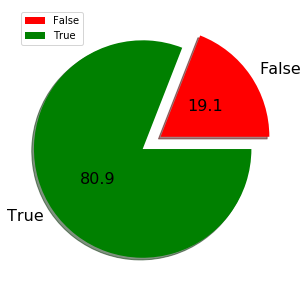

In [104]:
df.groupBy('rated').count().toPandas().plot.pie(y="count", figsize=(5, 5), 
                                                labels=["False", "True"], autopct='%.1f', 
                                                colors=["r", "g"], pctdistance=0.5,
                                               textprops={"size":16}, explode=[0.1,0.1],
                                               shadow = True)
plt.ylabel("")
plt.show()

**Let's visualize the victory status**

In [105]:
df.groupBy('victory_status').count().show()

+--------------+-----+
|victory_status|count|
+--------------+-----+
|        resign|10695|
|     outoftime| 1598|
|          mate| 5974|
|          draw|  846|
+--------------+-----+



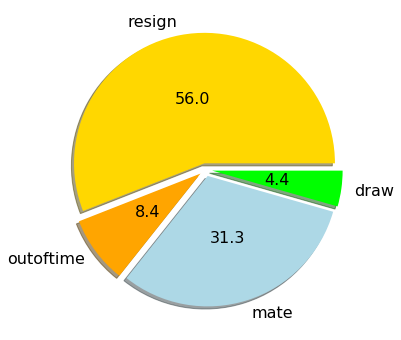

In [106]:
df.groupBy('victory_status').count().toPandas().plot.pie(y="count", figsize=(6, 6), 
                                                labels=["resign", "outoftime", "mate", "draw"], autopct='%.1f', 
                                                colors=["gold", "orange", "lightblue", "lime"], pctdistance=0.5,
                                               textprops={"size":16}, legend=None, explode=[0.05,0.05,0.05,0.05],
                                               shadow = True)
plt.ylabel("")
plt.show()

**Let's see how winners are distributed: we see that the white player (who moves first) has a slight advantage over the black one;**

**this is a well-known fact in the chess world**

In [107]:
df.groupBy('winner').count().show()

+------+-----+
|winner|count|
+------+-----+
| white| 9545|
| black| 8680|
|  draw|  888|
+------+-----+



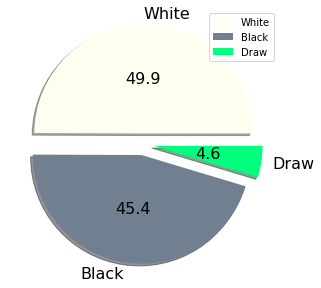

In [108]:
df.groupBy('winner').count().toPandas().plot.pie(y="count", figsize=(5, 5), 
                                                labels=["White", "Black", "Draw"], autopct='%.1f', 
                                                colors=["ivory", "slategrey", "springgreen"], pctdistance=0.5,
                                               textprops={"size":16}, explode=[0.1,0.1, 0.1],
                                               shadow = True)
plt.ylabel("")
plt.show()

In [109]:
df.select("moves").show()

+--------------------+
|               moves|
+--------------------+
|d4 c5 c3 cxd4 cxd...|
|e4 c5 c3 Nc6 d4 c...|
|e4 e5 Nf3 Nc6 d4 ...|
|d4 d5 Nf3 Nf6 Bf4...|
|e4 Nc6 d4 Nf6 e5 ...|
|d4 Nf6 Nc3 d6 e4 ...|
|d4 e6 c4 c5 d5 Qb...|
|d4 f5 e3 Nf6 Nf3 ...|
|d4 d5 c4 c6 Nf3 N...|
|e4 e5 Nf3 Nc6 Bb5...|
|d4 b6 Nf3 Bb7 e3 ...|
|e4 e5 Nf3 d6 Nc3 ...|
|e4 c5 Nf3 d6 d4 c...|
|e4 e5 Nf3 Nc6 Bc4...|
|e4 e5 Nf3 Nc6 Bc4...|
|e4 Nc6 Bc4 Nf6 Nf...|
|d3 e6 e3 Nc6 Nf3 ...|
|e4 Nc6 d4 d5 e5 B...|
|e4 h5 Nf3 g6 d4 e...|
|e4 c5 Nf3 d6 Nc3 ...|
+--------------------+
only showing top 20 rows



In [110]:
df.select(
        "id",
        f.split("moves", " ").alias("moves"),
        f.posexplode(f.split("moves", " ")).alias("pos", "val")
        ).show()

+--------+--------------------+---+----+
|      id|               moves|pos| val|
+--------+--------------------+---+----+
|YopBjBqM|[d4, c5, c3, cxd4...|  0|  d4|
|YopBjBqM|[d4, c5, c3, cxd4...|  1|  c5|
|YopBjBqM|[d4, c5, c3, cxd4...|  2|  c3|
|YopBjBqM|[d4, c5, c3, cxd4...|  3|cxd4|
|YopBjBqM|[d4, c5, c3, cxd4...|  4|cxd4|
|YopBjBqM|[d4, c5, c3, cxd4...|  5| Nf6|
|YopBjBqM|[d4, c5, c3, cxd4...|  6| Nc3|
|YopBjBqM|[d4, c5, c3, cxd4...|  7|  g6|
|YopBjBqM|[d4, c5, c3, cxd4...|  8|  b3|
|YopBjBqM|[d4, c5, c3, cxd4...|  9| Bg7|
|YopBjBqM|[d4, c5, c3, cxd4...| 10| Bb2|
|YopBjBqM|[d4, c5, c3, cxd4...| 11| O-O|
|YopBjBqM|[d4, c5, c3, cxd4...| 12|  e3|
|YopBjBqM|[d4, c5, c3, cxd4...| 13|  e6|
|YopBjBqM|[d4, c5, c3, cxd4...| 14| Nf3|
|YopBjBqM|[d4, c5, c3, cxd4...| 15|  a6|
|YopBjBqM|[d4, c5, c3, cxd4...| 16| Be2|
|YopBjBqM|[d4, c5, c3, cxd4...| 17|  d5|
|YopBjBqM|[d4, c5, c3, cxd4...| 18| O-O|
|YopBjBqM|[d4, c5, c3, cxd4...| 19| Nc6|
+--------+--------------------+---+----+
only showing top

In [17]:
def funz_moves(value):
    split_moves = value.split(" ")
    
    if len(split_moves) >= 4:
        fin = split_moves[:2] + split_moves[-2:]
        fin = " ".join(fin)
        return fin
    else:
        split_moves = " ".join(split_moves)
        return split_moves

udf_funz_moves = udf(funz_moves, StringType())

df = df.withColumn("moves_new", udf_funz_moves("moves"))

In [48]:
df.limit(3).toPandas()

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,increment1,increment2,moves_new
0,YopBjBqM,True,139,draw,draw,1736,1893,d4 c5 c3 cxd4 cxd4 Nf6 Nc3 g6 b3 Bg7 Bb2 O-O e...,A43,Old Benoni Defense,2,10,0,d4 c5 Rh3 Kd2
1,SipCSO1G,True,96,resign,black,2209,2044,e4 c5 c3 Nc6 d4 cxd4 cxd4 e6 Nc3 Bb4 Ne2 Nge7 ...,B22,Sicilian Defense: Alapin Variation,3,8,0,e4 c5 Re2 a3
2,tpi9ti3J,True,58,resign,black,1652,1624,e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Bb4+ c3 Ba5 Nf5 Qf6...,C45,Scotch Game: Malaniuk Variation,8,6,8,e4 e5 h3 Bd5


In [18]:
df_split2 = df.select(
        "id",
        f.split("moves_new", " ").alias("moves_new"),
        f.posexplode(f.split("moves_new", " ")).alias("pos", "val")
    )\
    .drop("val")\
    .select(
        "id",
        f.concat(f.lit("moves_new"),f.col("pos").cast("string")).alias("name"),
        f.expr("moves_new[pos]").alias("val")
    )\
    .groupBy("id").pivot("name").agg(f.first("val"))
    

In [19]:
#column_list = ['id', 'rated', 'turns', 'victory_status', 'winner',
# 'white_rating', 'black_rating', 'moves', 'opening_eco',
# 'opening_name', 'opening_ply', 'increment1', 'increment2'] + \
#["moves{0}".format(i) for i in range(349)]

#column_list = ["id"] + ["moves{0}".format(i) for i in range(349)]
column_list = ["id"] + ["moves_new{0}".format(i) for i in [0,1,2,3]]

In [20]:
df_split2 = df_split2.select(column_list)

In [21]:
df = df.join(df_split2, ["id"])
df = df.drop("moves")

In [22]:
#df.show(10)

In [23]:
print(df.count())
print(len(df.columns))

19113
17


In [145]:
df.select("turns").describe().show()

+-------+------------------+
|summary|             turns|
+-------+------------------+
|  count|             19113|
|   mean|60.513838748495786|
| stddev| 33.48826396268022|
|    min|                 1|
|    max|               349|
+-------+------------------+



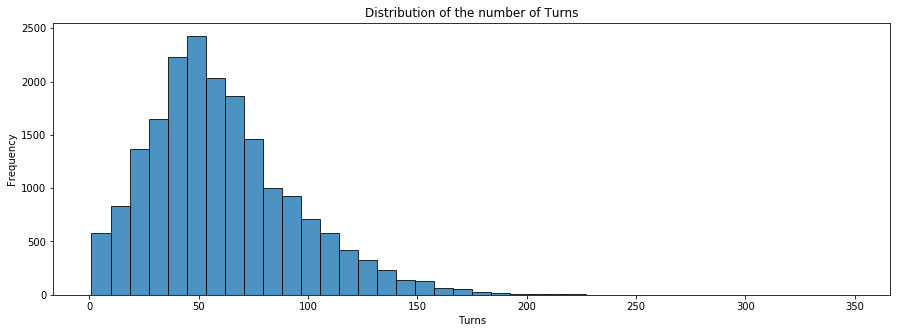

In [34]:
df.select("turns").toPandas().plot(kind="hist", figsize=(15,5), bins=40, edgecolor="black", alpha=0.8, legend=None)
plt.title("Distribution of the number of Turns")
plt.xlabel("Turns")
plt.show()

In [35]:
df.select("opening_ply").describe().show()

+-------+------------------+
|summary|       opening_ply|
+-------+------------------+
|  count|             19113|
|   mean| 4.815779835713912|
| stddev|2.7982829080050102|
|    min|                 1|
|    max|                28|
+-------+------------------+



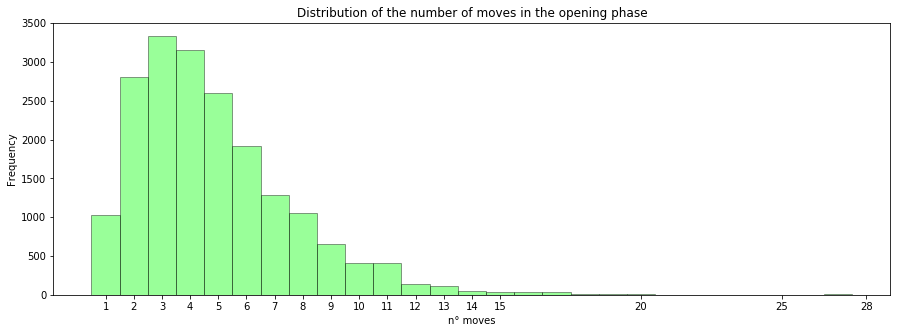

In [36]:
df.select("opening_ply").toPandas().plot(kind="hist", figsize=(15,5), bins=27, color="lime",
                                         edgecolor="black", alpha=0.4, legend=None)
plt.title("Distribution of the number of moves in the opening phase")
plt.xticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5,11.5,12.5,13.5,14.5,15.5,20.5, 25.5,28.5], 
           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,28])
plt.xlabel("n° moves")
plt.show()

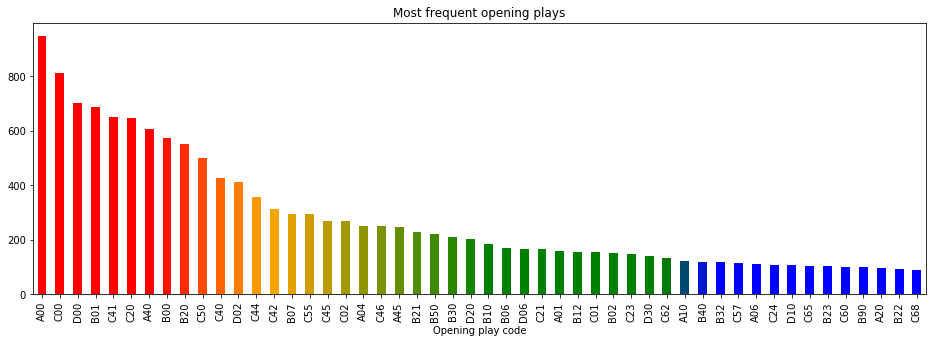

In [37]:
import matplotlib.colors as mcolors
clist = [(0, "red"), (0.125, "red"), (0.25, "orange"), (0.5, "green"), 
         (0.7, "green"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

N = 50
x = np.arange(N).astype(float)
y = np.random.uniform(0, 5, size=(N,))


df.select("opening_eco").toPandas()["opening_eco"].value_counts().iloc[:N].plot(kind="bar", 
                                                                                 figsize=(16,5),
                                                                                 color=rvb(x/N) )
plt.title("Most frequent opening plays")
plt.xlabel("Opening play code")
plt.show()

In [38]:
df.select("increment1").describe().show()

+-------+------------------+
|summary|        increment1|
+-------+------------------+
|  count|             19113|
|   mean|13.785277036571967|
| stddev|17.072446733601073|
|    min|                 0|
|    max|               180|
+-------+------------------+



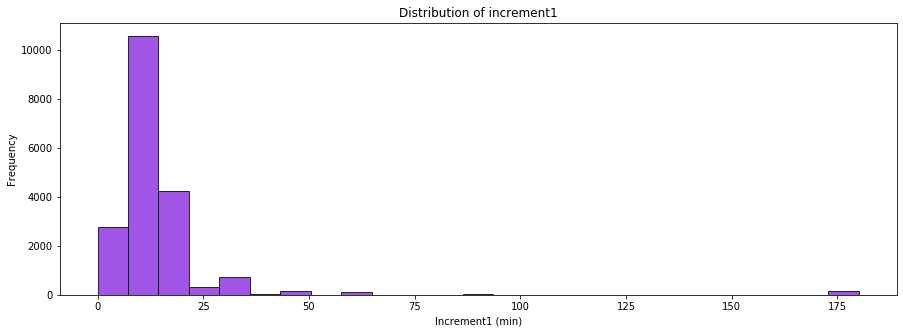

In [39]:
df.select("increment1").toPandas().plot(kind="hist", figsize=(15,5), color="blueviolet",
                                        bins=25, edgecolor="black", alpha=0.8, legend=None)
plt.title("Distribution of increment1")
plt.xlabel("Increment1 (min)")
plt.show()

In [40]:
df.select("increment2").describe().show()

+-------+------------------+
|summary|        increment2|
+-------+------------------+
|  count|             19113|
|   mean|5.1464971485376445|
| stddev|13.808620253370899|
|    min|                 0|
|    max|               180|
+-------+------------------+



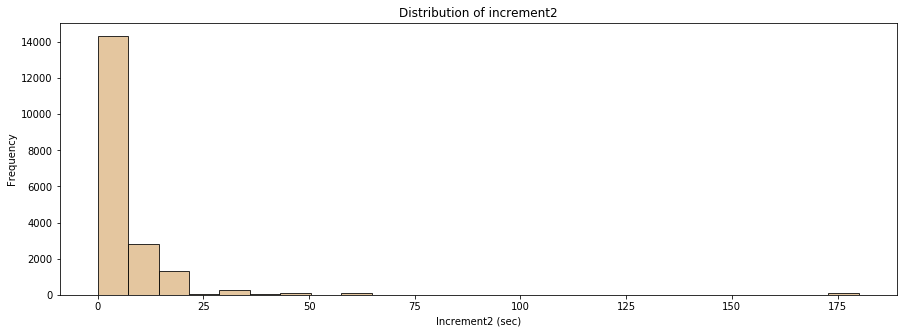

In [41]:
df.select("increment2").toPandas().plot(kind="hist", figsize=(15,5), color="burlywood",
                                        bins=25, edgecolor="black", alpha=0.8, legend=None)
plt.title("Distribution of increment2")
plt.xlabel("Increment2 (sec)")
plt.show()

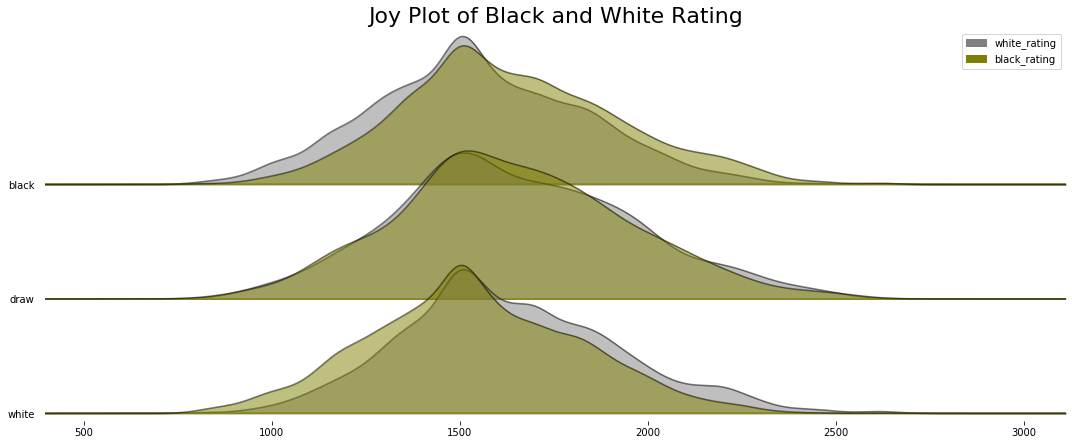

In [42]:
# Draw Plot
fig, axes = joypy.joyplot(df.select("white_rating", "black_rating", "winner").toPandas(), 
                          column=['white_rating', 'black_rating'],by = "winner", ylim='own', 
                          color=["grey", "olive"], legend=True,
                          figsize=(15,6), alpha=0.5)

# Decoration

plt.title('Joy Plot of Black and White Rating', fontsize=22)
plt.show()

In [146]:
df.groupby("winner").mean().select(["winner","avg(white_rating)", "avg(black_rating)"]).show()

+------+------------------+------------------+
|winner| avg(white_rating)| avg(black_rating)|
+------+------------------+------------------+
| white|1634.7327396542692|1540.4346778418019|
| black|1550.8154377880185| 1639.265668202765|
|  draw|1649.3164414414414|1642.1903153153153|
+------+------------------+------------------+



In [45]:
#df.createTempView("dataframe")

In [46]:
df_tt1 = spark.sql("select white_rating, black_rating from dataframe where winner = '{0}'".format("white")).toPandas()
df_tt2 = spark.sql("select white_rating, black_rating from dataframe where winner = '{0}'".format("black")).toPandas()
df_tt3 = spark.sql("select white_rating, black_rating from dataframe where winner = '{0}'".format("draw")).toPandas()

In [47]:
print(scipy.stats.ttest_ind(df_tt1.white_rating, df_tt1.black_rating))
print(scipy.stats.ttest_ind(df_tt2.white_rating, df_tt2.black_rating))
print(scipy.stats.ttest_ind(df_tt3.white_rating, df_tt3.black_rating))

Ttest_indResult(statistic=22.837035036935784, pvalue=6.591467723433094e-114)
Ttest_indResult(statistic=-20.374237387648417, pvalue=3.2960912165480816e-91)
Ttest_indResult(statistic=0.49189177002182255, pvalue=0.6228567156066165)


In [50]:
ct = pd.crosstab(df.select("opening_eco").toPandas()["opening_eco"], 
                 df.select("opening_name").toPandas()["opening_name"])

In [51]:
ct.head(2)

opening_name,Alekhine Defense,Alekhine Defense #2,Alekhine Defense #3,Alekhine Defense: Balogh Variation,Alekhine Defense: Brooklyn Variation,Alekhine Defense: Exchange Variation,Alekhine Defense: Four Pawns Attack,Alekhine Defense: Four Pawns Attack | 6...Nc6,Alekhine Defense: Four Pawns Attack | Fianchetto Variation,Alekhine Defense: Four Pawns Attack | Main Line,...,Zukertort Opening: Quiet System,Zukertort Opening: Reversed Mexican Defense,Zukertort Opening: Ross Gambit,Zukertort Opening: Santasiere's Folly,Zukertort Opening: Sicilian Invitation,Zukertort Opening: Slav Invitation,Zukertort Opening: Tennison Gambit,Zukertort Opening: The Walrus,Zukertort Opening: Vos Gambit,Zukertort Opening: Wade Defense
opening_eco,,,,,,,,,,,,,,,,,,,,,
A00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
list_incongr = []
z = ct.apply(Counter).values
for i, elem in enumerate(z):
    if elem[0]!=364:
        list_incongr.append(i)

In [53]:
ct2 = ct.iloc[:, list_incongr].T

In [54]:
list_incongr_col = [i for i in range(365) if ct2.sum().iloc[i]!=0]

In [55]:
ct3 = ct.iloc[list_incongr_col, list_incongr].T
ct3.head(3)

opening_eco,A02,A03,A04,A06,A07,A08,A09,A20,A21,A34,...,D45,D46,D52,D74,D76,E01,E06,E12,E91,E94
opening_name,,,,,,,,,,,,,,,,,,,,,
Alekhine Defense,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bird Opening,58,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Borg Defense: Borg Gambit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
#df.toPandas().head(2)

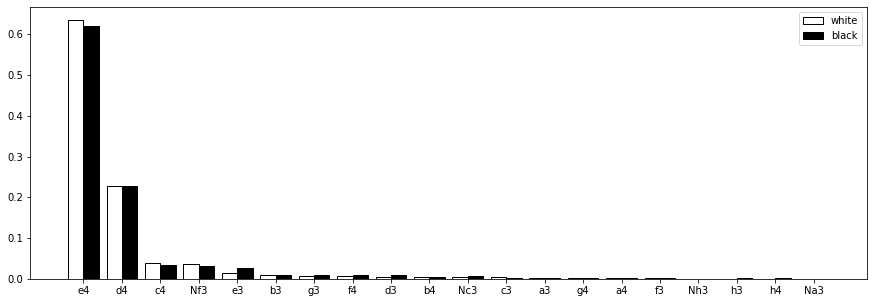

In [147]:
def subcategorybar(X, vals, width=0.8):
    plt.figure(figsize=(15,5))
    n = len(vals)
    _X = np.arange(len(X))
    labels=["white", "black"]
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i]/vals[i].sum(), 
                width=width/float(n), align="edge", label=labels[i], 
                color=labels[i], edgecolor="black")   
    plt.xticks(_X, X)
    plt.legend()

def moves_win(name_col):
    df_pd = df.select(name_col, "winner").toPandas()    

    X = list(df_pd[df_pd.winner == "white"]["{0}".format(name_col)].value_counts().index)
    X2 = list(df_pd[df_pd.winner == "black"]["{0}".format(name_col)].value_counts().index)
    
    list_uncommon1 = [i for i in X if i not in X2] 
    list_uncommon2 = [i for i in X2 if i not in X]
    
    X_mod = X + list_uncommon2
    
    if len(list_uncommon2) == 0:
        
        Y = df_pd[df_pd.winner == "white"]["{0}".format(name_col)].value_counts().reindex(X_mod).values
    
    else:
        
        for i in range(len(list_uncommon2)):
            Y = df_pd[df_pd.winner == "white"]["{0}".format(name_col)].\
            value_counts().append(pd.Series([0], [list_uncommon2[i]]))
        
        Y = Y.reindex(X_mod).values
    
    if len(list_uncommon1) == 0:
        
        Z = df_pd[df_pd.winner == "black"]["{0}".format(name_col)].value_counts().reindex(X_mod).values
    
    else:
        
        for i in range(len(list_uncommon1)):
            Z = df_pd[df_pd.winner == "black"]["{0}".format(name_col)].\
            value_counts().append(pd.Series([0], [list_uncommon1[i]]))
        
        Z = Z.reindex(X_mod).values

    subcategorybar(X_mod, [Y,Z])
    
    plt.show()
    
moves_win("moves_new0")

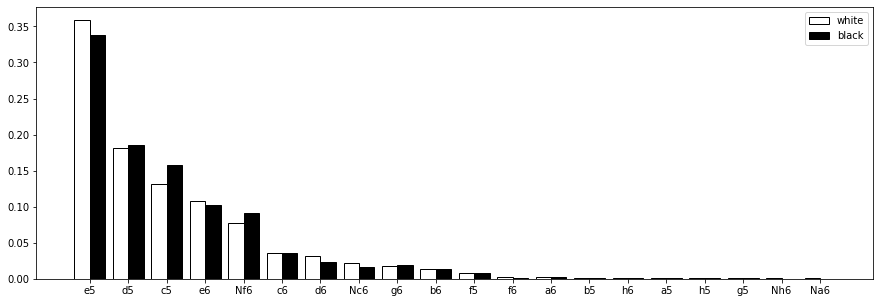

In [148]:
moves_win("moves_new1")

In [149]:
df.groupby("winner").avg().select("winner", "avg(opening_ply)", "avg(turns)").show()

+------+-----------------+------------------+
|winner| avg(opening_ply)|        avg(turns)|
+------+-----------------+------------------+
| white|4.849449973808277| 57.77852278679937|
| black|4.748271889400922|60.795852534562215|
|  draw|5.113738738738738| 87.15878378378379|
+------+-----------------+------------------+



In [150]:
df.groupby("victory_status").avg().select("victory_status", "avg(opening_ply)", "avg(turns)").show()

+--------------+-----------------+-----------------+
|victory_status| avg(opening_ply)|       avg(turns)|
+--------------+-----------------+-----------------+
|        resign|4.993174380551659|53.91182795698925|
|     outoftime|4.677096370463079|72.97872340425532|
|          mate|4.492132574489454|65.56896551724138|
|          draw|5.120567375886525|84.73404255319149|
+--------------+-----------------+-----------------+



### Feature Engineering

In [24]:
df = df.drop("id", "moves_new", "opening_eco")

In [35]:
df = df.fillna({'moves_new1':0, 'moves_new2':0, 'moves_new3':0}) #moves_new had some NaNs

In [30]:
df.count()

19113

In [36]:
df.na.drop().count()

19113

In [37]:
#from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+-----+--------------+------+------------+------------+------------+-----------+----------+----------+----------+----------+----------+----------+
|rated|turns|victory_status|winner|white_rating|black_rating|opening_name|opening_ply|increment1|increment2|moves_new0|moves_new1|moves_new2|moves_new3|
+-----+-----+--------------+------+------------+------------+------------+-----------+----------+----------+----------+----------+----------+----------+
|    0|    0|             0|     0|           0|           0|           0|          0|         0|         0|         0|         0|         0|         0|
+-----+-----+--------------+------+------------+------------+------------+-----------+----------+----------+----------+----------+----------+----------+



In [38]:
# Helper function to select features to scale given their skew
def select_features_to_scale(datf, lower_skew=-2, upper_skew=2, dtypes='int', drop_cols=[]):
    
    # Empty Selected Feature List for Output
    selected_features = []
    
    # Select Features to Scale based on Inputs ('int' type, drop 'ID' columns or others, skew bounds)
    feature_list = list(datf.toPandas().select_dtypes(include=[dtypes]).columns.drop(drop_cols))
    
    # Loop through 'feature_list' to select features based on Kurtosis / Skew
    for feature in feature_list:

        if datf.toPandas()[feature].kurtosis() < -2 or datf.toPandas()[feature].kurtosis() > 2:
            
            selected_features.append(feature)
    
    # Return feature list to scale
    return selected_features

df_mod = df.drop("moves150")
for i in range(151,349):
    df_mod = df_mod.drop("moves{0}".format(i))

df_mod.limit(5).toPandas()

In [39]:
df.columns

['rated',
 'turns',
 'victory_status',
 'winner',
 'white_rating',
 'black_rating',
 'opening_name',
 'opening_ply',
 'increment1',
 'increment2',
 'moves_new0',
 'moves_new1',
 'moves_new2',
 'moves_new3']

In [40]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

# Spark Pipeline
cat_features = ['rated', 'opening_name'] + ["moves_new{0}".format(i) for i in range(4)]

num_features = ['turns','white_rating','black_rating','opening_ply','increment1', 'increment2']

label = 'winner'

# Pipeline Stages List
stages = []

# Loop for StringIndexer and OHE for Categorical Variables
for features in cat_features:
    
    # Index Categorical Features
    string_indexer = StringIndexer(inputCol=features, outputCol=features + "_index")
    
    # One Hot Encode Categorical Features
    encoder = OneHotEncoderEstimator(inputCols=[string_indexer.getOutputCol()],
                                     outputCols=[features + "_class_vec"])
    # Append Pipeline Stages
    stages += [string_indexer, encoder]
    
# Index Label Feature
label_str_index =  StringIndexer(inputCol=label, outputCol="label_index")

# Scale Feature: Select the Features to Scale using helper 'select_features_to_scale' function above and Standardize 
#unscaled_features = select_features_to_scale(df)

#unscaled_assembler = VectorAssembler(inputCols=unscaled_features, outputCol="unscaled_features")
#scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features")

#stages += [unscaled_assembler, scaler]

# Create list of Numeric Features that Are Not Being Scaled
num_unscaled_diff_list = list(set(num_features)) # - set(unscaled_features))

# Assemble or Concat the Categorical Features and Numeric Features
assembler_inputs = [feature + "_class_vec" for feature in cat_features] + num_unscaled_diff_list

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features") 

stages += [label_str_index, assembler]

# Assemble Final Training Data of Scaled, Numeric, and Categorical Engineered Features
#assembler_final = VectorAssembler(inputCols=["scaled_features","assembled_inputs"], outputCol="features")

#assembler_final = VectorAssembler(inputCols=["assembled_inputs"], outputCol="features")

#stages += [assembler_final]

In [41]:
stages

[StringIndexer_95121cc6e4c2,
 OneHotEncoderEstimator_1e6015990e9f,
 StringIndexer_ac0dc6938a3e,
 OneHotEncoderEstimator_a15ddb88cb21,
 StringIndexer_a46126404246,
 OneHotEncoderEstimator_700aaa0d65a6,
 StringIndexer_1f3bc0381a48,
 OneHotEncoderEstimator_3c6b5a8fbc97,
 StringIndexer_c908676c3f97,
 OneHotEncoderEstimator_736d307240ac,
 StringIndexer_5408ddd90b97,
 OneHotEncoderEstimator_c5c1f4feb668,
 StringIndexer_237f24e67c3c,
 VectorAssembler_50cf050f64ad]

In [42]:
#2min50sec
# Set Pipeline
pipeline = Pipeline(stages=stages)
print("pipeline initialized")

# Fit Pipeline to Data
pipeline_model = pipeline.fit(df)
print("model fitted")

# Transform Data using Fitted Pipeline
df_transform = pipeline_model.transform(df)

pipeline initialized
model fitted


In [180]:
# Preview Newly Transformed Data
df_transform.limit(5).toPandas()

,rated,turns,victory_status,winner,white_rating,black_rating,opening_name,opening_ply,increment1,increment2,...,moves_new0_index,moves_new0_class_vec,moves_new1_index,moves_new1_class_vec,moves_new2_index,moves_new2_class_vec,moves_new3_index,moves_new3_class_vec,label_index,features
0,True,139,draw,draw,1736,1893,Old Benoni Defense,2,10,0,...,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",336.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",109.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,True,96,resign,black,2209,2044,Sicilian Defense: Alapin Variation,3,8,0,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",96.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",113.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,True,58,resign,black,1652,1624,Scotch Game: Malaniuk Variation,8,6,8,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",320.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,False,39,resign,white,1812,1820,Queen's Pawn Game: London System,5,10,0,...,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",51.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",577.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,True,93,resign,white,2217,1970,King's Pawn Game: Nimzowitsch Defense,3,10,0,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",402.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",223.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [43]:
# Select only 'features' and 'label_index' for Final Dataframe
df_transform_fin = df_transform.select('features','label_index')
df_transform_fin.limit(5).toPandas()

,features,label_index
0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0
1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0


In [135]:
#df_transform_fin = df_transform_fin.withColumn("label_index",df_transform_fin["label_index"].cast("int"))

In [44]:
df_transform_fin.show(3)

+--------------------+-----------+
|            features|label_index|
+--------------------+-----------+
|(4952,[0,124,1478...|        2.0|
|(4952,[0,52,1477,...|        1.0|
|(4952,[0,518,1477...|        1.0|
+--------------------+-----------+
only showing top 3 rows



In [45]:
df_transform_fin.count()

19113

In [46]:
df_transform_fin.na.drop().count()

19113

In [47]:
# Split Data into Train / Test Sets
train_data, test_data = df_transform_fin.randomSplit([.8, .2],seed=42)

In [48]:
train_data.show(5)

+--------------------+-----------+
|            features|label_index|
+--------------------+-----------+
|(4952,[0,3,1477,1...|        0.0|
|(4952,[0,9,1477,1...|        1.0|
|(4952,[0,9,1477,1...|        1.0|
|(4952,[0,9,1477,1...|        1.0|
|(4952,[0,10,1478,...|        0.0|
+--------------------+-----------+
only showing top 5 rows



In [54]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label_index',
                            maxDepth = 5, seed=42)
dtModel = dt.fit(train_data)

predictions = dtModel.transform(test_data)
predictions.select('label_index', 'rawPrediction', 'prediction', 'probability').show(10)

+-----------+--------------------+----------+--------------------+
|label_index|       rawPrediction|prediction|         probability|
+-----------+--------------------+----------+--------------------+
|        0.0|[1375.0,1715.0,16...|       1.0|[0.42268675069166...|
|        1.0|   [54.0,135.0,12.0]|       1.0|[0.26865671641791...|
|        0.0|[2392.0,1734.0,18...|       0.0|[0.55473098330241...|
|        0.0|   [359.0,78.0,10.0]|       0.0|[0.80313199105145...|
|        0.0|[2392.0,1734.0,18...|       0.0|[0.55473098330241...|
|        0.0|[1375.0,1715.0,16...|       1.0|[0.42268675069166...|
|        2.0|[1375.0,1715.0,16...|       1.0|[0.42268675069166...|
|        0.0|  [966.0,361.0,79.0]|       0.0|[0.68705547652916...|
|        1.0|    [60.0,433.0,9.0]|       1.0|[0.11952191235059...|
|        0.0|[2392.0,1734.0,18...|       0.0|[0.55473098330241...|
+-----------+--------------------+----------+--------------------+
only showing top 10 rows



In [55]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Set Accuracy = %g" % (accuracy))

Test Set Accuracy = 0.59337


In [58]:
dt2 = RandomForestClassifier(featuresCol = 'features', labelCol = 'label_index', numTrees=20,
                             maxDepth = 5, seed=42)
dt2Model = dt2.fit(train_data)

predictions2 = dt2Model.transform(test_data)
predictions2.select('label_index', 'rawPrediction', 'prediction', 'probability').show(10)

+-----------+--------------------+----------+--------------------+
|label_index|       rawPrediction|prediction|         probability|
+-----------+--------------------+----------+--------------------+
|        0.0|[9.92118618275944...|       0.0|[0.49605930913797...|
|        1.0|[10.1693235631783...|       0.0|[0.50846617815891...|
|        0.0|[9.92118618275944...|       0.0|[0.49605930913797...|
|        0.0|[10.1693235631783...|       0.0|[0.50846617815891...|
|        0.0|[10.0308165621266...|       0.0|[0.50154082810633...|
|        0.0|[9.92118618275944...|       0.0|[0.49605930913797...|
|        2.0|[9.85599977960717...|       0.0|[0.49279998898035...|
|        0.0|[9.92118618275944...|       0.0|[0.49605930913797...|
|        1.0|[9.92118618275944...|       0.0|[0.49605930913797...|
|        0.0|[10.2961729806778...|       0.0|[0.51480864903389...|
+-----------+--------------------+----------+--------------------+
only showing top 10 rows



In [60]:
evaluator2 = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy2 = evaluator2.evaluate(predictions2)
print("Test Set Accuracy = %g" % (accuracy2))

Test Set Accuracy = 0.548822


In [89]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

print("Feature Importance according to RandomForestClassifier")
ExtractFeatureImp(dt2Model.featureImportances, df_transform_fin, "features").head(15)

Feature Importance according to RandomForestClassifier


,idx,name,score
2900,2894,moves_new3_class_vec_Qxf2#,0.086035
1522,1516,moves_new2_class_vec_Kh8,0.061678
2901,2895,moves_new3_class_vec_Qf2#,0.050262
1526,1520,moves_new2_class_vec_Kg1,0.045928
1533,1527,moves_new2_class_vec_Ke2,0.042275
0,4946,black_rating,0.036453
1546,1540,moves_new2_class_vec_Kd2,0.035300
2898,2892,moves_new3_class_vec_Qf7#,0.035298
1543,1537,moves_new2_class_vec_Kd1,0.031475
1536,1530,moves_new2_class_vec_Ke1,0.031467


In [63]:
dt3 = LogisticRegression(featuresCol = 'features', labelCol = 'label_index', maxIter = 10)

dt3Model = dt3.fit(train_data)

predictions3 = dt3Model.transform(test_data)
predictions3.select('label_index', 'rawPrediction', 'prediction', 'probability').show(10)

+-----------+--------------------+----------+--------------------+
|label_index|       rawPrediction|prediction|         probability|
+-----------+--------------------+----------+--------------------+
|        0.0|[0.07832550896203...|       1.0|[0.35426958643812...|
|        1.0|[-0.7747465818665...|       1.0|[0.01446011173150...|
|        0.0|[2.32551393344361...|       0.0|[0.91492911171162...|
|        0.0|[2.44407460467075...|       0.0|[0.79324394198562...|
|        0.0|[6.27017707591990...|       0.0|[0.99983544741904...|
|        0.0|[-2.1241437294911...|       1.0|[3.04282149222622...|
|        2.0|[1.82497119028347...|       0.0|[0.69026548653943...|
|        0.0|[2.20055334692985...|       0.0|[0.92918447626717...|
|        1.0|[1.14902753173228...|       1.0|[0.10971668049453...|
|        0.0|[0.68414187201709...|       1.0|[0.36142987688250...|
+-----------+--------------------+----------+--------------------+
only showing top 10 rows



In [64]:
evaluator3 = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy3 = evaluator3.evaluate(predictions3)
print("Test Set Accuracy = %g" % (accuracy3))

Test Set Accuracy = 0.699042


In [68]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder()\
    .addGrid(dt3.aggregationDepth,[2,5,10])\
    .addGrid(dt3.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(dt3.fitIntercept,[False, True])\
    .addGrid(dt3.maxIter,[10, 100, 1000])\
    .addGrid(dt3.regParam,[0.01, 0.5, 2.0]) \
    .build()

paramGrid = ParamGridBuilder()\
    .addGrid(dt3.aggregationDepth,[2,5])\
    .addGrid(dt3.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(dt3.regParam,[0.01, 0.5, 2.0]) \
    .build()

In [69]:
#1h20m with 
'''paramGrid = ParamGridBuilder()\
    .addGrid(dt3.aggregationDepth,[2,5])\  
    .addGrid(dt3.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(dt3.regParam,[0.01, 0.5, 2.0]) \
    .build() '''

#Create 3-fold CrossValidator
cv = CrossValidator(estimator=dt3, estimatorParamMaps=paramGrid, evaluator=evaluator3, numFolds=3)
# Run cross validations
cvModel = cv.fit(train_data)
print("Model fitted")
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train=cvModel.transform(train_data)
predict_test=cvModel.transform(test_data)
print("The accuracy on the training set after cv is {}".format(evaluator3.evaluate(predict_train)))
print("The accuracy on the test set after cv is {}".format(evaluator3.evaluate(predict_test)))

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.4.3/libexec/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LogisticRegression' object has no attribute '_java_obj'


Model fitted
The accuracy on the training set after cv is 0.7899291896144768
The accuracy on the test set after cv is 0.7311577311577312


In [77]:
bestmod = cvModel.bestModel
bestParams = bestmod.extractParamMap()
# best are aggregationDepth=2, elasticNetParam=0.5, regParam=0.01

In [78]:
bestParams

{Param(parent='LogisticRegression_38de24403f56', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_38de24403f56', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.5,
 Param(parent='LogisticRegression_38de24403f56', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_38de24403f56', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_38de24403f56', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_38de24403f56', name='labelCol', doc='label column name'): 'label_index',
 Param(parent='LogisticRegression_38de24403f56', name='maxIter', doc='maximum number of iterations (>= 

In [173]:
#train_data.select("label_index").count()

In [174]:
#train_data.select("label_index").distinct().count()

In [119]:
# Number of Classes
nb_classes = 3#train_data.select("label_index").distinct().count()
print(nb_classes)

# Number of Inputs or Input Dimensions
input_dim = 4956#len(train_data.select("features").first()[0])  #4953
print(input_dim)

3
4956


In [141]:
# Set up Deep Learning Model / Architecture
model = Sequential()
model.add(Dense(512, input_shape=(input_dim,), activity_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(256, activity_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [142]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               2537984   
_________________________________________________________________
activation_46 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_47 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               65792     
__________

In [143]:
le = LabelEncoder()

dfp = df.toPandas()
col_y = le.fit_transform(dfp.winner)
dfp2 = dfp.drop(["victory_status", "winner", "rated"], 1)
dfp3 = pd.get_dummies(dfp2)
dfp3["winner"] = col_y

X_train, X_test, y_train, y_test = train_test_split(dfp3.drop(["winner"],1), 
                                                    dfp3.winner, test_size=0.2, random_state=42)

In [144]:
le.inverse_transform([0, 1, 2])

array(['black', 'draw', 'white'], dtype=object)

In [145]:
dfp.head()

,rated,turns,victory_status,winner,white_rating,black_rating,opening_name,opening_ply,increment1,increment2,moves_new0,moves_new1,moves_new2,moves_new3
0,True,139,draw,draw,1736,1893,Old Benoni Defense,2,10,0,d4,c5,Rh3,Kd2
1,True,96,resign,black,2209,2044,Sicilian Defense: Alapin Variation,3,8,0,e4,c5,Re2,a3
2,True,58,resign,black,1652,1624,Scotch Game: Malaniuk Variation,8,6,8,e4,e5,h3,Bd5
3,False,39,resign,white,1812,1820,Queen's Pawn Game: London System,5,10,0,d4,d5,h6,Qc4
4,True,93,resign,white,2217,1970,King's Pawn Game: Nimzowitsch Defense,3,10,0,e4,Nc6,Rd2+,Bxd2


In [146]:
#without StandardScaler
history1 = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_test,y_test))

Train on 15290 samples, validate on 3823 samples
Epoch 1/30
15290/15290 [==============================] - 10s 645us/step - loss: 474516.2953 - acc: 0.5012 - val_loss: 16100.8306 - val_acc: 0.5177
Epoch 2/30
15290/15290 [==============================] - 7s 468us/step - loss: 11158.7465 - acc: 0.4976 - val_loss: 8310.4972 - val_acc: 0.5443
Epoch 3/30
15290/15290 [==============================] - 7s 434us/step - loss: 6999.5011 - acc: 0.5167 - val_loss: 5511.2367 - val_acc: 0.5582
Epoch 4/30
15290/15290 [==============================] - 7s 440us/step - loss: 4642.3637 - acc: 0.5315 - val_loss: 3668.3742 - val_acc: 0.5739
Epoch 5/30
15290/15290 [==============================] - 7s 442us/step - loss: 3111.8474 - acc: 0.5519 - val_loss: 2472.1366 - val_acc: 0.5749
Epoch 6/30
15290/15290 [==============================] - 7s 447us/step - loss: 2102.4305 - acc: 0.5712 - val_loss: 1688.1430 - val_acc: 0.6066
Epoch 7/30
15290/15290 [==============================] - 7s 440us/step - loss: 14

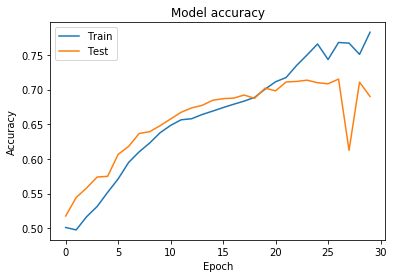

In [147]:
# Plot training & validation accuracy values
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [148]:
model.evaluate(X_test, y_test)

3823/3823 [==============================] - 1s 212us/step


[1.619167909677073, 0.6900340047395264]

In [123]:
#le = LabelEncoder()
scaler = StandardScaler()

dfp = df.toPandas()
col_y = le.fit_transform(dfp.winner)

for col_name in ["turns", "white_rating", "black_rating", "opening_ply", "increment1", "increment2"]:
    dfp[col_name]= scaler.fit_transform(dfp[col_name].values.reshape(-1, 1))

dfp2 = dfp.drop(["victory_status", "winner", "rated"], 1)
dfp3 = pd.get_dummies(dfp2)
dfp3["winner"] = col_y

X_train, X_test, y_train, y_test = train_test_split(dfp3.drop(["winner"],1), 
                                                    dfp3.winner, test_size=0.2, random_state=42)

In [124]:
dfp.head()

,rated,turns,victory_status,winner,white_rating,black_rating,opening_name,opening_ply,increment1,increment2,moves_new0,moves_new1,moves_new2,moves_new3
0,True,2.343753,draw,draw,0.478251,1.043109,Old Benoni Defense,-1.006279,-0.221724,-0.372712,d4,c5,Rh3,Kd2
1,True,1.059687,resign,black,2.109200,1.563021,Sicilian Defense: Alapin Variation,-0.648908,-0.338875,-0.372712,e4,c5,Re2,a3
2,True,-0.075068,resign,black,0.188611,0.116909,Scotch Game: Malaniuk Variation,1.137949,-0.456026,0.206652,e4,e5,h3,Bd5
3,False,-0.642446,resign,white,0.740306,0.791761,Queen's Pawn Game: London System,0.065835,-0.221724,-0.372712,d4,d5,h6,Qc4
4,True,0.970101,resign,white,2.136785,1.308230,King's Pawn Game: Nimzowitsch Defense,-0.648908,-0.221724,-0.372712,e4,Nc6,Rd2+,Bxd2


In [135]:
#with StandardScaler
history2 = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test,y_test))

Train on 15290 samples, validate on 3823 samples
Epoch 1/20
15290/15290 [==============================] - 13s 863us/step - loss: 1.5176 - acc: 0.5857 - val_loss: 0.9866 - val_acc: 0.7146
Epoch 2/20
15290/15290 [==============================] - 10s 673us/step - loss: 0.9287 - acc: 0.7600 - val_loss: 1.0151 - val_acc: 0.7264
Epoch 3/20
15290/15290 [==============================] - 11s 691us/step - loss: 0.8530 - acc: 0.8101 - val_loss: 1.1182 - val_acc: 0.7154
Epoch 4/20
15290/15290 [==============================] - 12s 755us/step - loss: 0.8160 - acc: 0.8547 - val_loss: 1.2339 - val_acc: 0.7086
Epoch 5/20
15290/15290 [==============================] - 13s 858us/step - loss: 0.7902 - acc: 0.8776 - val_loss: 1.3570 - val_acc: 0.7086
Epoch 6/20
15290/15290 [==============================] - 12s 801us/step - loss: 0.7404 - acc: 0.9002 - val_loss: 1.3812 - val_acc: 0.6830
Epoch 7/20
15290/15290 [==============================] - 10s 685us/step - loss: 0.7279 - acc: 0.9122 - val_loss: 1.4

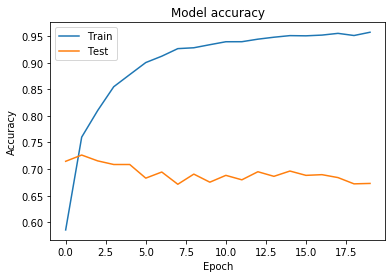

In [136]:
# Plot training & validation accuracy values
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [138]:
#with StandardScaler, less epochs
history3 = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test,y_test))

Train on 15290 samples, validate on 3823 samples
Epoch 1/5
15290/15290 [==============================] - 16s 1ms/step - loss: 1.4989 - acc: 0.5768 - val_loss: 1.0055 - val_acc: 0.7031
Epoch 2/5
15290/15290 [==============================] - 12s 782us/step - loss: 0.9270 - acc: 0.7542 - val_loss: 1.0049 - val_acc: 0.7185
Epoch 3/5
15290/15290 [==============================] - 11s 725us/step - loss: 0.8554 - acc: 0.8076 - val_loss: 1.1710 - val_acc: 0.6921
Epoch 4/5
15290/15290 [==============================] - 11s 699us/step - loss: 0.8206 - acc: 0.8449 - val_loss: 1.1969 - val_acc: 0.7063
Epoch 5/5
15290/15290 [==============================] - 11s 732us/step - loss: 0.7833 - acc: 0.8772 - val_loss: 1.3178 - val_acc: 0.7002


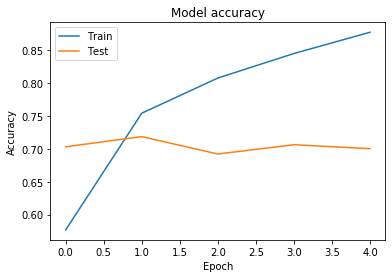

In [139]:
# Plot training validation accuracy values
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [140]:
model.evaluate(X_test, y_test)

3823/3823 [==============================] - 1s 230us/step


[0.9364024672463338, 0.7002354172583871]

In [159]:
model2 = Sequential()
model2.add(Dense(1024, input_shape=(input_dim,), activity_regularizer=regularizers.l2(0.01)))
model2.add(Activation('relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(512, activity_regularizer=regularizers.l2(0.01)))
model2.add(Activation('relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [160]:
history4 = model2.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_test,y_test))

Train on 15290 samples, validate on 3823 samples
Epoch 1/30
15290/15290 [==============================] - 19s 1ms/step - loss: 761454.4000 - acc: 0.4653 - val_loss: 28340.7632 - val_acc: 0.4311
Epoch 2/30
15290/15290 [==============================] - 14s 921us/step - loss: 20517.6986 - acc: 0.4780 - val_loss: 15308.5920 - val_acc: 0.4988
Epoch 3/30
15290/15290 [==============================] - 13s 881us/step - loss: 12844.3107 - acc: 0.4868 - val_loss: 9921.8374 - val_acc: 0.4959
Epoch 4/30
15290/15290 [==============================] - 15s 1ms/step - loss: 8283.3197 - acc: 0.4942 - val_loss: 6419.6704 - val_acc: 0.4962
Epoch 5/30
15290/15290 [==============================] - 15s 998us/step - loss: 5339.0282 - acc: 0.4963 - val_loss: 4171.8381 - val_acc: 0.4949
Epoch 6/30
15290/15290 [==============================] - 14s 944us/step - loss: 3475.9095 - acc: 0.4980 - val_loss: 2737.0189 - val_acc: 0.4949
Epoch 7/30
15290/15290 [==============================] - 13s 857us/step - loss

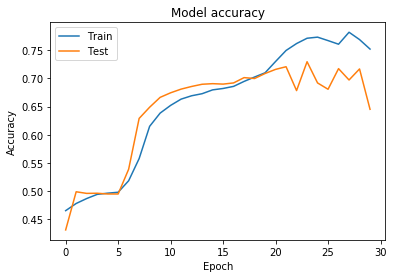

In [161]:
# Plot training validation accuracy values
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [162]:
model2.evaluate(X_test, y_test)

3823/3823 [==============================] - 1s 369us/step


[1.838927321648554, 0.6453047345328824]